In [7]:
!pip install -q datasets transformers
!pip install ipywidgets
!pip install huggingface_hub
import os

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [41]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [42]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir="C:/Users/srite/FoodImageRecognition/FoodClassification")
ds = ds['train']

Resolving data files:   0%|          | 0/638 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [43]:
data = ds.train_test_split(test_size=0.15)
data
#data.push_to_hub("Saathvik2111/indian_food_images")

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 542
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 96
    })
})

In [44]:
#data = load_dataset("Saathvik2111/indian_food_images")

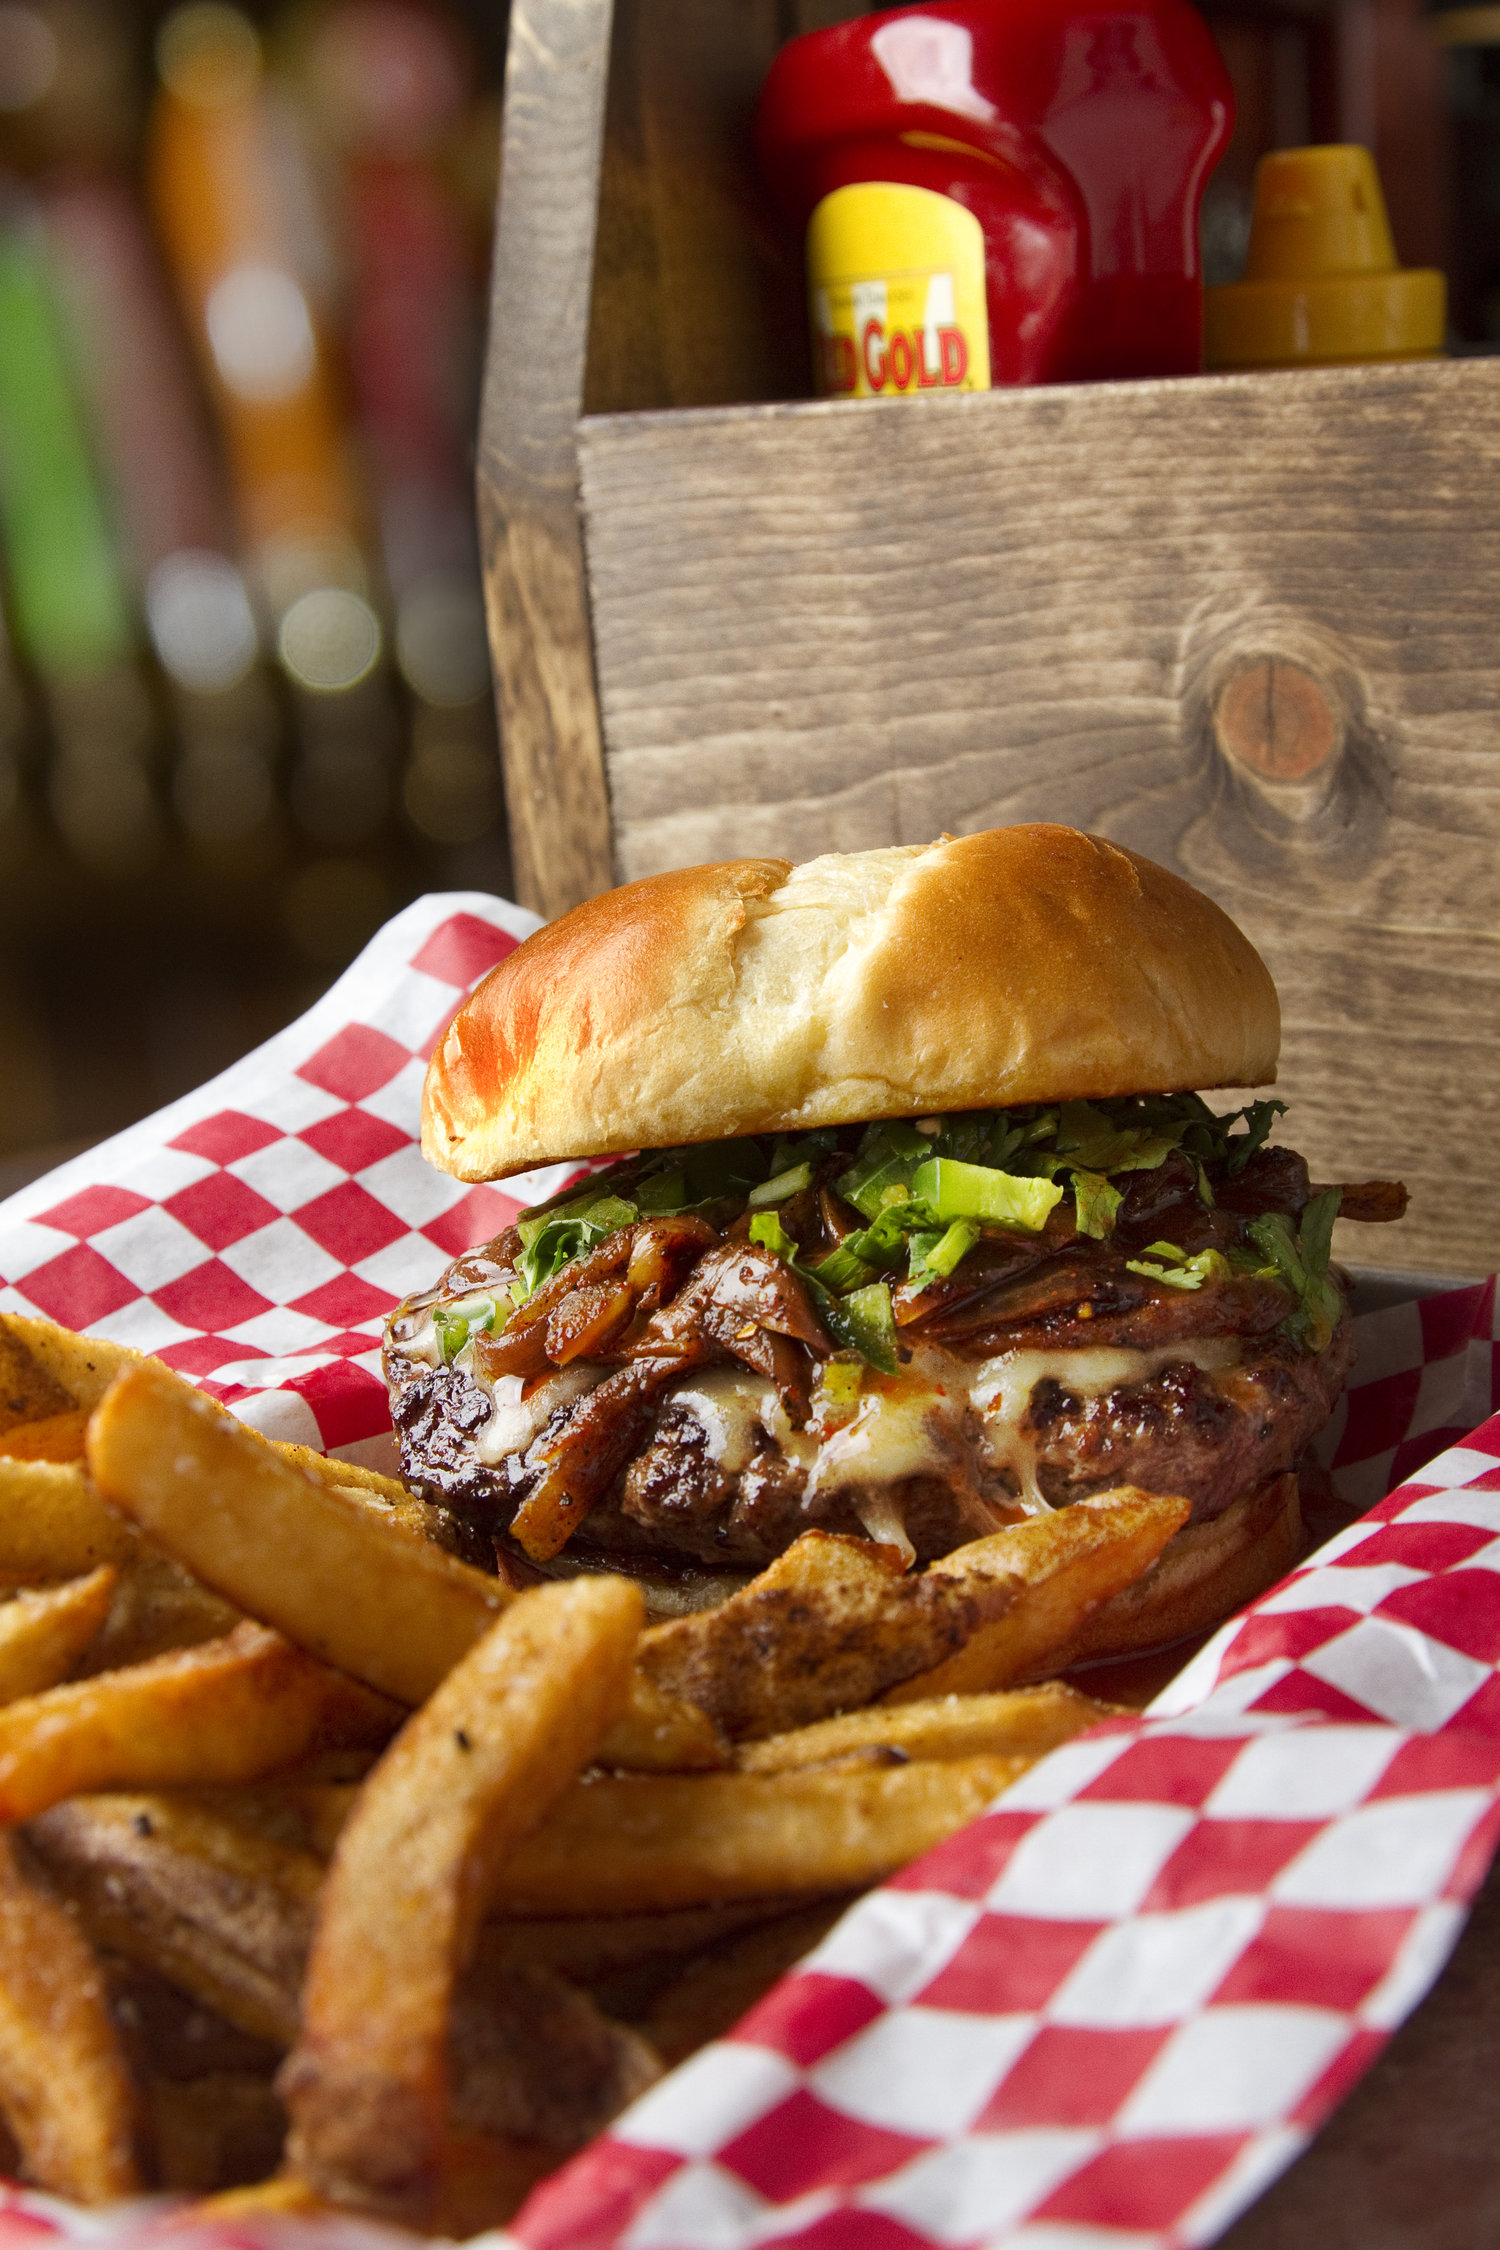

In [68]:
ex = data['train'][400]
image = ex['image']
image

In [46]:
labels = data['train'].features['label']
labels.int2str(ex['label'])

'burger'

In [47]:
from datasets import load_metric
metric = load_metric("accuracy")

c:\pyhton\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [48]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 542
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 96
    })
})

In [49]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [50]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

c:\pyhton\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [51]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size["height"]),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size["height"]),
            CenterCrop(feature_extractor.size["height"]),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [52]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [53]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [54]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1400x1400>,
 'label': 0,
 'pixel_values': tensor([[[ 0.9686,  0.9843,  0.9843,  ...,  0.9843,  0.9765,  0.9686],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9843,  0.9765,  0.9686],
          [ 1.0000,  0.9922,  0.9922,  ...,  0.9765,  0.9686,  0.9608],
          ...,
          [ 0.6235,  0.6235,  0.6549,  ...,  0.5608,  0.5529,  0.5529],
          [ 0.6314,  0.6392,  0.6471,  ...,  0.5608,  0.5529,  0.5529],
          [ 0.6235,  0.6706,  0.6863,  ...,  0.5608,  0.5529,  0.5529]],
 
         [[ 0.2549,  0.3020,  0.3176,  ...,  0.4902,  0.4902,  0.4824],
          [ 0.2863,  0.2863,  0.2784,  ...,  0.4824,  0.4745,  0.4667],
          [ 0.3490,  0.3176,  0.2863,  ...,  0.4510,  0.4431,  0.4353],
          ...,
          [-0.0588, -0.0667, -0.0588,  ...,  0.1451,  0.1451,  0.1451],
          [-0.0667, -0.0588, -0.0667,  ...,  0.1451,  0.1451,  0.1451],
          [-0.0667, -0.0275, -0.0275,  ...,  0.1451,  0.1451,  0.1451

In [55]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
!pip install transformers[torch]
!pip install accelerate -U

from transformers import TrainingArguments

training_args = TrainingArguments(
    'C:/Users/srite/FoodImageRecognition/finetuned-indian-food',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)

In [57]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [58]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [59]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [60]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1709452390.Rayala.17836.0:   0%|          | 0.00/5.86k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1709453856.Rayala.17836.1:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

events.out.tfevents.1709451918.Rayala.16776.0:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

events.out.tfevents.1709454022.Rayala.17836.2:   0%|          | 0.00/8.04k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 156464645GF
  train_loss               =      0.0551
  train_runtime            =  1:40:14.01
  train_samples_per_second =        0.36
  train_steps_per_second   =       0.023


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0107
  eval_runtime            = 0:01:32.62
  eval_samples_per_second =      1.036
  eval_steps_per_second   =       0.13


In [61]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1709460222.Rayala.17836.3:   0%|          | 0.00/411 [00:00<?, ?B/s]

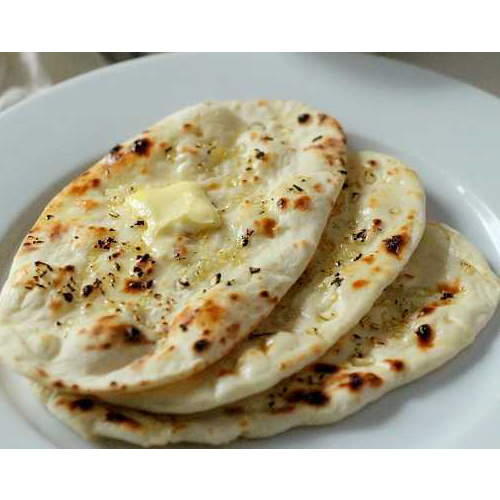

In [89]:
from PIL import Image
import requests

url = 'https://huggingface.co/Saathvik2111/finetuned-indian-food/resolve/fd42a5ff778c4a1b1f6e783dfcf307fb995d8f6d/022.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [95]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "Saathvik2111/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [96]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [97]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [98]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: butter_naan
